# Dataset analysis

In [1]:
cd /mnt/sda/otani/Experiments/moment_retrieval/

/mnt/sda/otani/Experiments/moment_retrieval


In [2]:
%matplotlib inline
from typing import List
import json
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class, predict
from src.toolbox.visualization import plot_performance_per_class
from src.toolbox.data_converters import Charade2Instances
from src.toolbox.baseline import SegmentGeneratorKDE
import seaborn as sns

In [3]:
train_data = Charade2Instances(pd.read_csv('data/processed/train.csv'))

In [4]:
def get_key_tokens(sentences: List[str]):
    simplified_sentences = []

    for i, sentence in enumerate(sentences):
        key_tokens = sentence2token(sentence)
        simplified_sentences.append(key_tokens)
        
    return simplified_sentences

sentences = [query[1] for query, _ in train_data]
simplified_sentences = get_key_tokens(sentences)

top-30 actions cover 93.2% of all actions


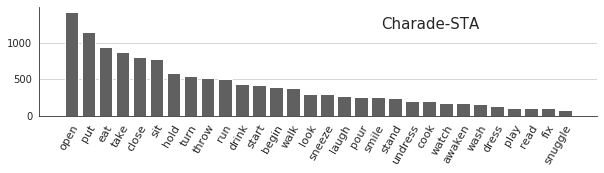

In [64]:
from collections import Counter

verbs = sum([x[0] for x in simplified_sentences], [])
verb_c = Counter(verbs)
k = 30

counts = [v for _, v in verb_c.most_common(k)]
top_actions = [k for k, _ in verb_c.most_common(k)]
sns.set_style("white")
plt.figure(figsize=(10, 2))
plt.bar(range(len(counts)), counts, color="#606060")
_ = plt.xticks(np.arange(len(counts))+.5, top_actions, rotation=60, fontsize=11, ha="right")
# plt.title(f"Top-{k} verb vocabulary")
sns.despine()
print(f"top-{k} actions cover {sum(counts)/sum(verb_c.values())*100:.1f}% of all actions")
plt.gca().yaxis.grid()
plt.text(0.7, 0.8, "Charade-STA", fontsize=15, transform=plt.gca().transAxes, ha="center")
plt.savefig("reports/figures/dataset visualization/charade-action-vocab.pdf",
           bbox_inches="tight")

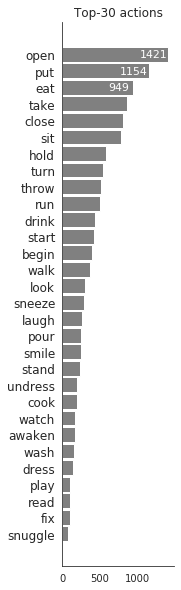

In [51]:
plt.figure(figsize=(2, 10))
bars = plt.barh(range(len(counts)), counts, color="gray", height=.9)
_ = plt.yticks(range(len(counts)), top_actions, fontsize=12)
plt.title(f"Top-{k} actions")
plt.gca().invert_yaxis()

for bar in bars[:3]:
    plt.text(
        bar.get_x()+bar.get_width()-200,
        bar.get_y()+bar.get_height()*.5,
        f"{bar.get_width()}",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=11,
        color="w"
    )
sns.despine()

plt.savefig("reports/figures/dataset visualization/charade-action-vocab-hbar.pdf",
           bbox_inches="tight")

1.110896196002579


(array([7.090e+02, 0.000e+00, 9.740e+03, 0.000e+00, 0.000e+00, 1.837e+03,
        0.000e+00, 1.180e+02, 0.000e+00, 4.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

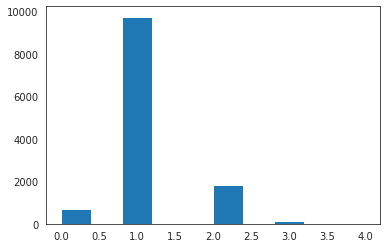

In [19]:
actions_per_query = [len(x[0]) for x in simplified_sentences]
print(np.mean(actions_per_query))
plt.hist(actions_per_query)

('1AR0K', 'the person puts the broom down.') (14.6, 20.7, 59.38)


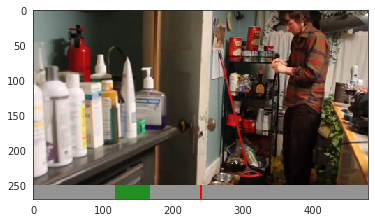

In [34]:
from random import choice as rchoice
from skvideo.io import vread, vwrite
import matplotlib.colors as mcolors
import os

instence = rchoice(train_data)
gt_q, gt_location = instence

vid_file = f"data/raw/video/{gt_q[0]}.mp4"
vid_arr = vread(vid_file)
    
N, H, W, C = vid_arr.shape

fps = N / gt_location[-1]

gt_start_sec, gt_end_sec, duration = gt_location

gt_start_i = gt_start_sec / duration * W
gt_end_i = gt_end_sec / duration * W

time_line = np.zeros((N, 20, W, C))
time_line[:, :, int(gt_start_i):int(gt_end_i), :] += np.asarray(mcolors.to_rgb(mcolors.CSS4_COLORS["limegreen"])) * 255 * .7
time_line[np.where(time_line==0)] = 147.7
step = 1 / N * W
for n in range(N):
    time_line[n, :, int(step * n): int(step*n+3), :] = [255, 0, 0]

vid_arr[:, -20:, :, :] = time_line
plt.imshow(vid_arr[int(N/2)])
print(gt_q, gt_location)

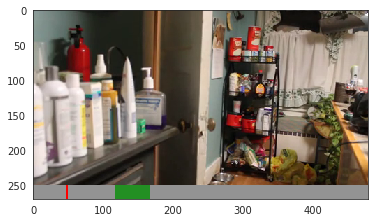

In [37]:
plt.imshow(vid_arr[int(N*.1)])

In [38]:
import shutil
shutil.copyfile("data/raw/video/1AR0K.mp4", "data/tmp/1AR0K.mp4")

'data/tmp/1AR0K.mp4'

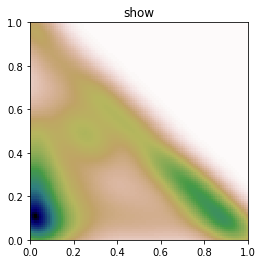

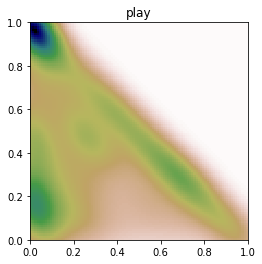

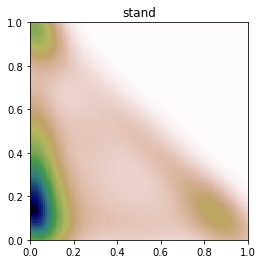

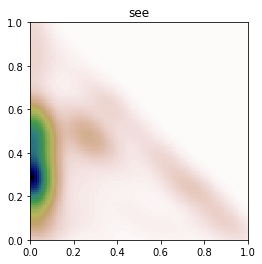

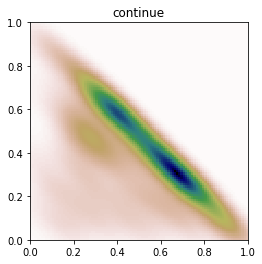

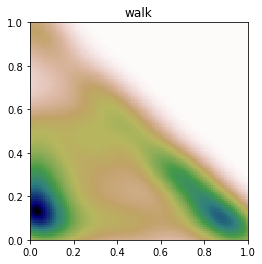

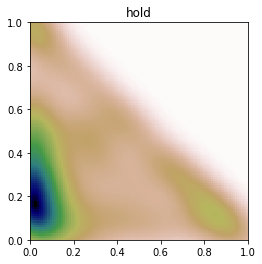

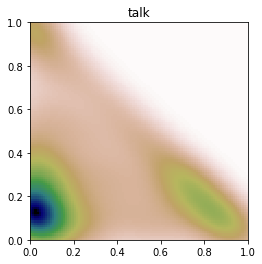

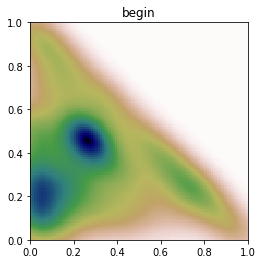

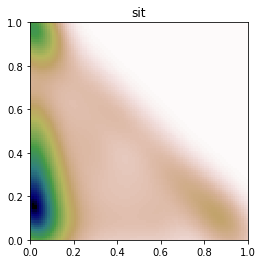

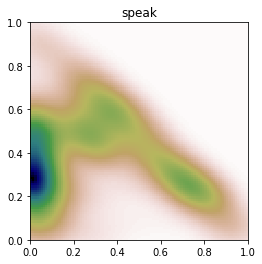

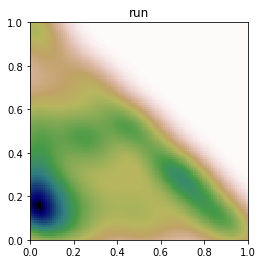

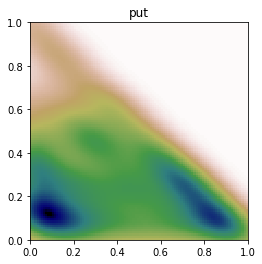

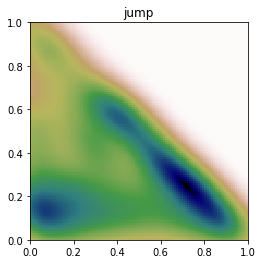

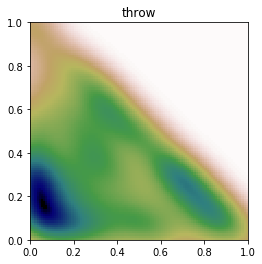

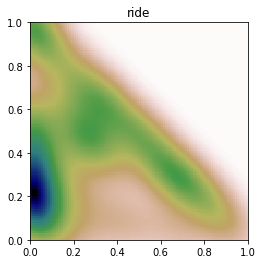

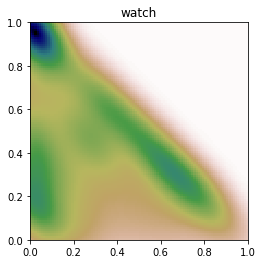

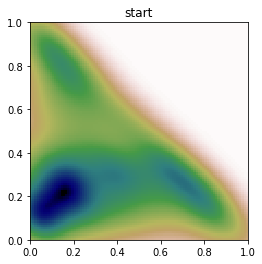

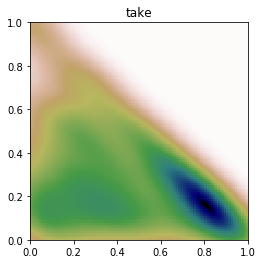

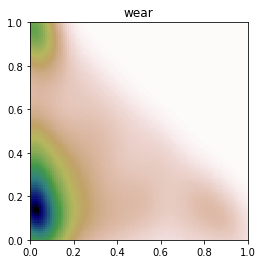

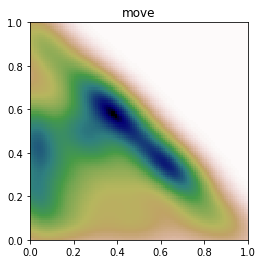

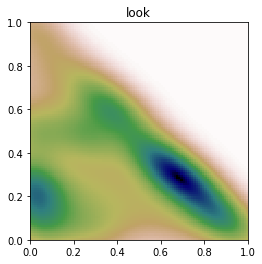

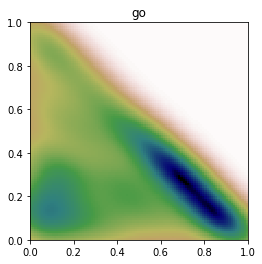

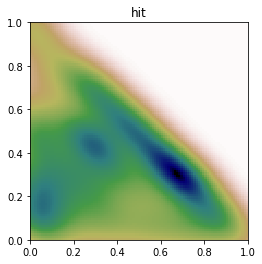

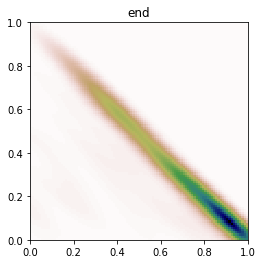

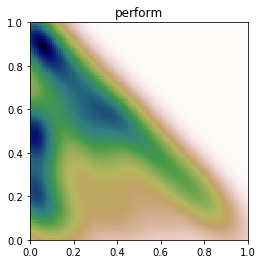

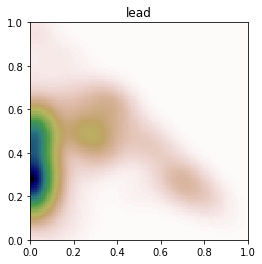

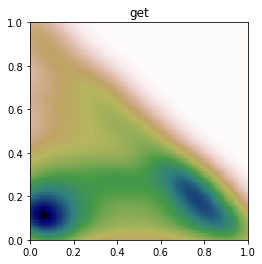

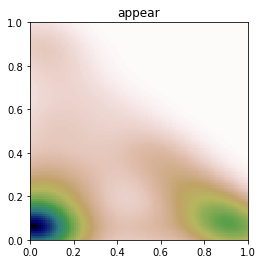

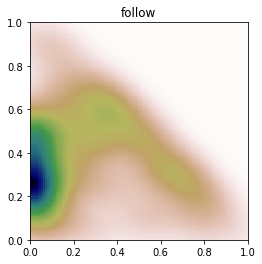

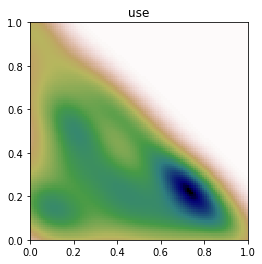

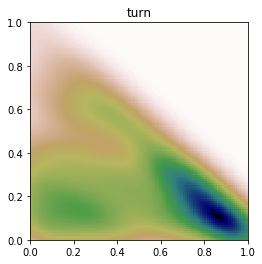

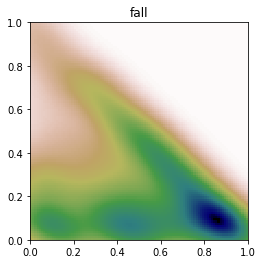

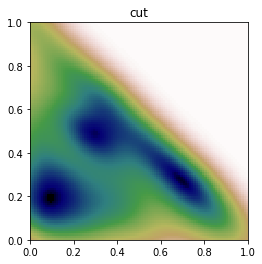

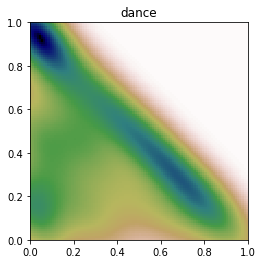

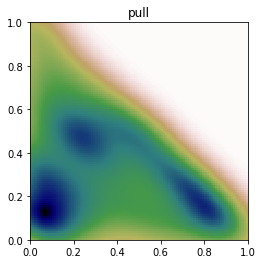

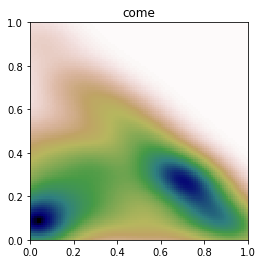

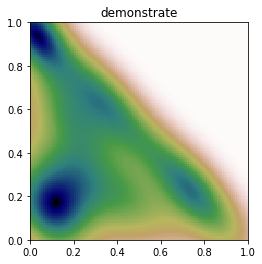

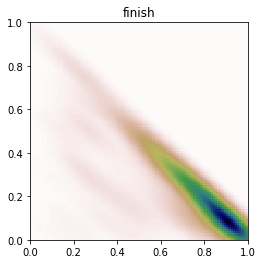

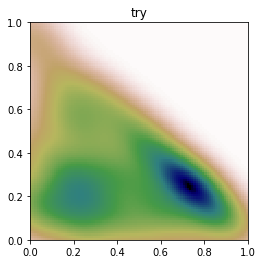

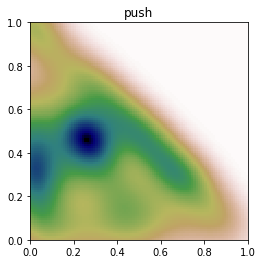

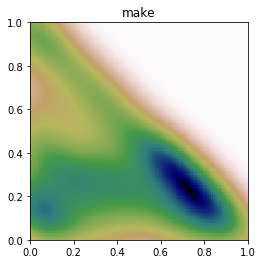

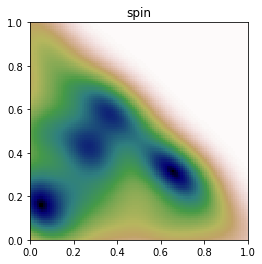

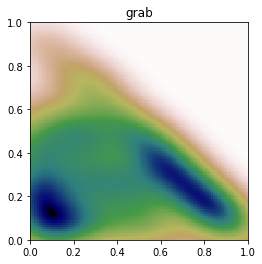

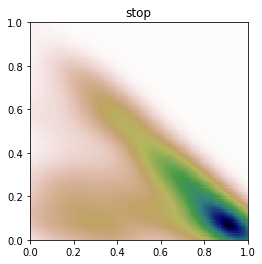

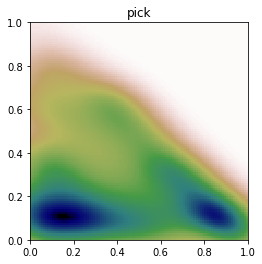

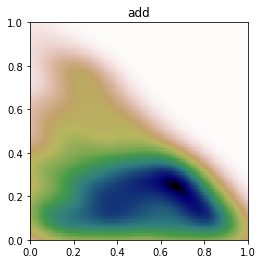

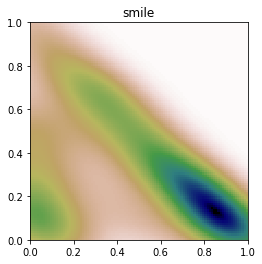

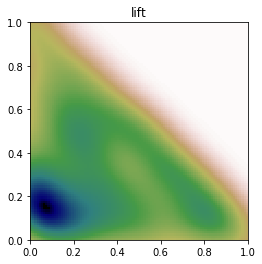

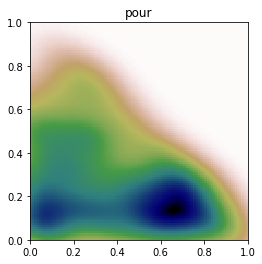

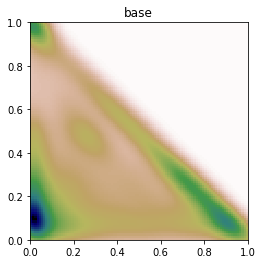

In [96]:
for action, kernel in segment_generator.kernels.items():
    X, Y = np.mgrid[0:1:100j, 0:1:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)
    plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[0, 1, 0, 1])
    plt.title(action)
    plt.show()

0.41898377390111985

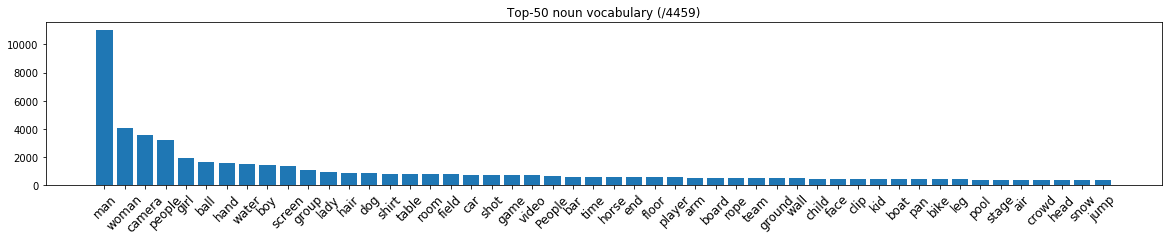

In [32]:
nouns = sum([x[1] for x in simplified_sentences], [])
noun_c = Counter(nouns)
k = 50
counts = [v for _, v in noun_c.most_common(k)]
top_objs = [k for k, _ in noun_c.most_common(k)]
plt.figure(figsize=(20, 3))
plt.bar(range(len(counts)), counts)
_ = plt.xticks(range(len(counts)), top_objs, rotation=45, fontsize=12)
plt.title(f"Top-{k} noun vocabulary (/{len(noun_c)})")

sum(counts)/sum(noun_c.values())

In [103]:
segment_generator = SegmentGeneratorKDE()
for action in top_actions:
    indices = [i for i, query in enumerate(simplified_sentences) if action in query[0]]
    sub_train = [train_data[i] for i in indices]
    segment_generator.fit(action, sub_train)
segment_generator.fit("base", train_data)

#instances: 3930
#instances: 2589
#instances: 2475
#instances: 2354
#instances: 2004
#instances: 1918
#instances: 1787
#instances: 1741
#instances: 1672
#instances: 1504
#instances: 1242
#instances: 1129
#instances: 1109
#instances: 1041
#instances: 1008
#instances: 952
#instances: 908
#instances: 839
#instances: 812
#instances: 801
#instances: 767
#instances: 774
#instances: 757
#instances: 736
#instances: 723
#instances: 710
#instances: 655
#instances: 647
#instances: 592
#instances: 578
#instances: 567
#instances: 536
#instances: 527
#instances: 517
#instances: 502
#instances: 450
#instances: 451
#instances: 443
#instances: 395
#instances: 391
#instances: 391
#instances: 385
#instances: 375
#instances: 373
#instances: 371
#instances: 350
#instances: 333
#instances: 347
#instances: 339
#instances: 326
#instances: 37421


In [102]:
# use all verbs

predictions = []
for instance in val_data[::10]:
    query, location = instance
    length = location[-1]
    
    actions, objects = sentence2token(query[1])
    
    if len(actions):
        n = 100 // len(actions)

        samples = []
        likelifood = []

        for action in actions:
            sample, score = segment_generator.sample(action, n)
            samples.append(sample)
            likelifood.append(score)

        samples = np.vstack(samples)
        likelifood = np.hstack(likelifood)
    else:
        samples, likelifood = segment_generator.sample("base", 100)
    
    bbox = samples.copy()
    bbox[:, 1] = bbox.sum(axis=1)

    keep = _nms(bbox, likelifood, 0.45)
    bbox = bbox[keep]
    likelifood = likelifood[keep]

    location = np.hstack([bbox * length, np.ones((len(bbox),1)) * length])
    
    predictions.append((query, location.tolist(), likelifood.tolist()))
    
    if len(predictions) % 1000 == 0:
        print(len(predictions))
        
results = evaluate(val_data[::10], predictions)
summary = accumulate_metrics(results)

1000
R@1 IoU>0.3 0.25
R@1 IoU>0.5 0.17
R@1 IoU>0.7 0.08
R@5 IoU>0.3 0.57
R@5 IoU>0.5 0.42
R@5 IoU>0.7 0.23
R@10 IoU>0.3 0.80
R@10 IoU>0.5 0.64
R@10 IoU>0.7 0.35


In [105]:
# use only first seen verb

predictions = []
for instance in val_data[::10]:
    query, location = instance
    length = location[-1]
    
    actions, objects = sentence2token(query[1])
    
    if len(actions):
        actions = [action for action in actions if action in segment_generator.vocab]
        action = actions[0] if len(actions) else "base"
        samples, likelifood = segment_generator.sample(action, 100)
    else:
        samples, likelifood = segment_generator.sample("base", 100)
    
    bbox = samples.copy()
    bbox[:, 1] = bbox.sum(axis=1)

    keep = _nms(bbox, likelifood, 0.45)
    bbox = bbox[keep]
    likelifood = likelifood[keep]

    location = np.hstack([bbox * length, np.ones((len(bbox),1)) * length])
    
    predictions.append((query, location.tolist(), likelifood.tolist()))
    
    if len(predictions) % 1000 == 0:
        print(len(predictions))

results = evaluate(val_data[::10], predictions)
summary = accumulate_metrics(results)

1000
R@1 IoU>0.3 0.30
R@1 IoU>0.5 0.19
R@1 IoU>0.7 0.10
R@5 IoU>0.3 0.56
R@5 IoU>0.5 0.41
R@5 IoU>0.7 0.23
R@10 IoU>0.3 0.78
R@10 IoU>0.5 0.61
R@10 IoU>0.7 0.34


In [125]:
from typing import Callable

def get_first_action(result: Result, action_vocab: List[str]) -> str:
    query, _, _, _ = result
    video_id, sentence = query
    actions, objects = sentence2token(sentence)
    
    if len(actions) == 0:
        action = "OoV"
    
    else:
        if actions[0] in action_vocab:
            action = actions[0] 
        else:
            action = "OoV"
    
    return action

def categorize_results(results: List[Result], cat_fn=Callable):
    keyed_results = {}
    for result in results:
        cls_label = cat_fn(result)
        keyed_results.setdefault(cls_label, []).append(result)
    return keyed_results

def summarize_results_per_class(keyed_results: dict) -> dict:
    metrics_per_cls = {}
    for cls_label, results in keyed_results.items():
        is_success = [metrics["R@1 IoU>0.5"] for _, _, _, metrics in results]
        n_success = sum(is_success)
        n_instance = len(is_success)
        rate_success = n_success / n_instance
        metrics_per_cls[cls_label] = {
            "n_success": n_success,
            "n_instance": n_instance,
            "rate_success": rate_success
        }
    return metrics_per_cls

def plot_performance_per_class(metrics_per_cls: dict) -> None:
    order = np.argsort([metrics["rate_success"] for metrics in metrics_per_cls.values()])[::-1]
    keys = list(metrics_per_cls.keys())
    n_success = list([metrics["n_success"] for metrics in metrics_per_cls.values()])
    n_instance = list([metrics["n_instance"] for metrics in metrics_per_cls.values()])
    
    keys = [keys[i] for i in order]
    n_success = [n_success[i] for i in order]
    n_instance = [n_instance[i] for i in order]

    N_cls = len(keys)

    fig, ax1 = plt.subplots(figsize=(25, 5))
    _ = plt.xticks(np.arange(n), keys, rotation=45, fontsize=18)

    ax1.bar(np.arange(N_cls), n_instance, color="coral", alpha=.7)
    ax1.bar(np.arange(N_cls), n_success, color="limegreen", alpha=1)

    ax2 = ax1.twinx()
    ax2.plot(np.arange(N_cls), np.asarray(n_success) / np.asarray(n_instance), color="blue")
    ax2.set_ylim(0, 1)

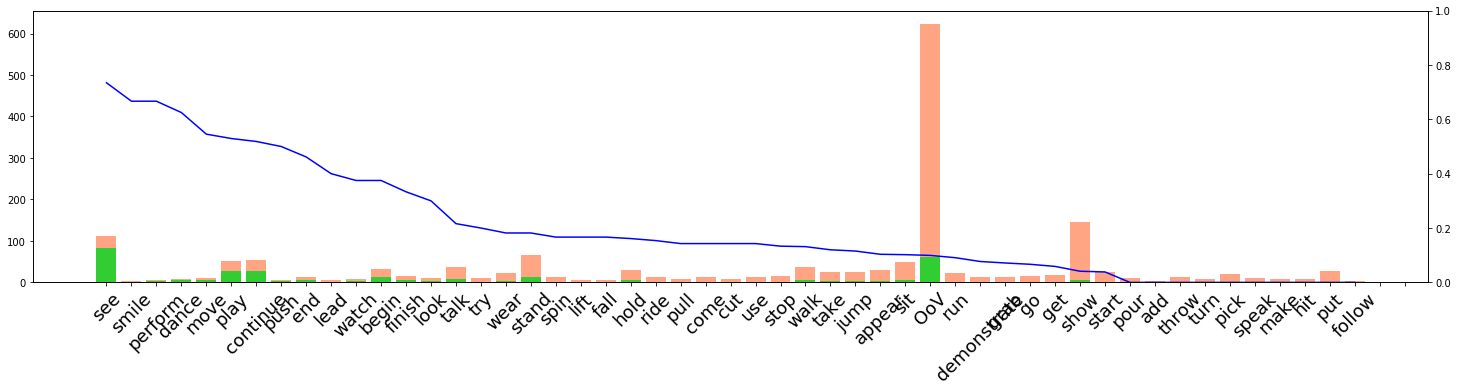

In [126]:
cat_fn = lambda x: get_first_action(x, segment_generator.vocab)
categorized_results = categorize_results(results, cat_fn)
metrics_per_cls = summarize_results_per_class(categorized_results)
plot_performance_per_class(metrics_per_cls)